## Importing libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import os
import warnings
warnings.filterwarnings('ignore')

## Loading the soil geochemical dataset

In [9]:
chem_soil = pd.read_csv("sarig_rs_chem_exp_25elements_soil.csv")

Checking what chemical elements are included in the dataset.

In [10]:
chem_soil['CHEM_CODE'].unique()

array(['Ag', 'As', 'Au', 'Ba', 'Be', 'Bi', 'Cd', 'Ce', 'Co', 'Cs', 'Dy',
       'Er', 'Eu', 'Ga', 'In', 'Gd', 'Hf', 'Ho', 'La', 'Li', 'Lu', 'Mo',
       'Nb', 'Nd', 'Pb', 'Pd', 'Pr', 'Pt', 'Rb', 'Re', 'Sb', 'Sc', 'Se',
       'Sm', 'Sn', 'Sr', 'Ta', 'Tb', 'Te', 'Th', 'Tl', 'Tm', 'U', 'W',
       'Y', 'Yb', 'Zr', 'Cu', 'Ni', 'V', 'Ca', 'Cr', 'Fe', 'Mg', 'Mn',
       'P', 'Zn', 'K', 'Al', 'Ti', 'B', 'Ge', 'Hg', 'Na', 'S'],
      dtype=object)

## Working on the "VALUE" column

### By checking some values, we see that some are reported below detection limit. Once a non-numerical character is identified ("<"), the pandas library reads the entire column as if composed of string values.

In that sense, we need to address two issues:

* Converting the values to float type
* Value assignment when reading was below detection limit

Following usual practice, we use (lower detection limit/2).

A function was created to perform these two tasks.

In [15]:
chem_soil['VALUE'].unique()

array(['<0.05', '1', '3', ..., '5.66', '8.41', '9.77'], dtype=object)

In [16]:
def convert_num(value):
    try:
        value = value.split('<')[1]
        return (float(value))/2
    except:
        try:
            value = value.split('>')[1]
            return -(float(value))
        except:
            return float(value)

In [17]:
chem_soil['VALUE'] = chem_soil['VALUE'].apply(convert_num)

#### Checking the presence of negative values

No value detected.

In [18]:
chem_soil[chem_soil['VALUE'] < 0]

,Unnamed: 0,SAMPLE_NO,SAMPLE_SOURCE,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC,geometry


#### Checking the presence of spurious and null values in the form of a series of "nines": 999999

No value detected.

In [19]:
chem_soil['VALUE'].max()

75600.0

### Standardizing concentration units

By checking the unit column, it is noticed that a given element may be displayed in more than one concentration unit.

To distribute the elements in individual columns, one may find more convenient to have all of them standardized to a single unit.

A function was devised to have all elements in ppm and store them in a new column ("VALUEppm").


In [20]:
chem_soil[chem_soil["CHEM_CODE"] == 'Au']["UNIT"].unique()

array(['ppb', 'ppm'], dtype=object)

In [21]:
chem_soil[chem_soil["CHEM_CODE"] == 'Al']["UNIT"].unique()

array(['ppm', '%'], dtype=object)

In [22]:
def units(cols):
    value = cols[0]
    unit = cols[1]
    if unit == '%':
        return (value*10000)
    elif unit == 'ppb':
        return (value/1000)
    else:
        return value

In [23]:
chem_soil['VALUEppm'] = chem_soil[['VALUE','UNIT']].apply(units,axis=1)

Checking the head of the data with the newly created column VALUEppm

In [24]:
chem_soil.head()

,Unnamed: 0,SAMPLE_NO,SAMPLE_SOURCE,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC,geometry,VALUEppm
0,0,2073051.0,Soil,1983853.0,591171.74,6390087.47,53.0,135.971846,-32.623015,"Genalysis Laboratory Services Pty Ltd, W.A.",Ag,0.025,ppm,ARU25/MS,"Aqua Regia digest 25g, ICP-MS determination",POINT (135.9718458 -32.6230154),0.025
1,1,2073051.0,Soil,1983853.0,591171.74,6390087.47,53.0,135.971846,-32.623015,"Genalysis Laboratory Services Pty Ltd, W.A.",As,1.000,ppm,ARU25/MS,"Aqua Regia digest 25g, ICP-MS determination",POINT (135.9718458 -32.6230154),1.000
2,2,2073051.0,Soil,1983853.0,591171.74,6390087.47,53.0,135.971846,-32.623015,"Genalysis Laboratory Services Pty Ltd, W.A.",Au,3.000,ppb,ARU25/MS,"Aqua Regia digest 25g, ICP-MS determination",POINT (135.9718458 -32.6230154),0.003
3,3,2073051.0,Soil,1983853.0,591171.74,6390087.47,53.0,135.971846,-32.623015,"Genalysis Laboratory Services Pty Ltd, W.A.",Ba,216.000,ppm,ARU25/MS,"Aqua Regia digest 25g, ICP-MS determination",POINT (135.9718458 -32.6230154),216.000
4,4,2073051.0,Soil,1983853.0,591171.74,6390087.47,53.0,135.971846,-32.623015,"Genalysis Laboratory Services Pty Ltd, W.A.",Be,0.730,ppm,ARU25/MS,"Aqua Regia digest 25g, ICP-MS determination",POINT (135.9718458 -32.6230154),0.730


## Creating one column for each element

Designing functions that read the "CHEM_CODE" column and assign the "VALUEppm" to a new column according to the chemical element.

In [25]:
def trace_Ag(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Ag':
        return value

def trace_As(cols):
    element = cols[0]
    value = cols[1]
    if element == 'As':
        return value

def trace_Au(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Au':
        return value

def trace_Ba(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Ba':
        return value

def trace_Be(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Be':
        return value

def trace_Bi(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Bi':
        return value

def trace_Cd(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Cd':
        return value

def trace_Ce(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Ce':
        return value
    
def trace_Co(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Co':
        return value

def trace_Cs(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Cs':
        return value

def trace_Dy(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Dy':
        return value 

def trace_Er(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Er':
        return value

def trace_Eu(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Eu':
        return value

def trace_Ga(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Ga':
        return value

def trace_In(cols):
    element = cols[0]
    value = cols[1]
    if element == 'In':
        return value
    
def trace_Gd(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Gd':
        return value

def trace_Hf(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Hf':
        return value

def trace_Ho(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Ho':
        return value

def trace_La(cols):
    element = cols[0]
    value = cols[1]
    if element == 'La':
        return value
    
def trace_Li(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Li':
        return value

def trace_Lu(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Lu':
        return value

def trace_Mo(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Mo':
        return value
    
def trace_Nb(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Nb':
        return value
    
def trace_Nd(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Nd':
        return value

def trace_Pb(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Pb':
        return value
    
def trace_Pd(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Pd':
        return value

def trace_Pr(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Pr':
        return value
    
def trace_Pt(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Pt':
        return value

def trace_Rb(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Rb':
        return value

def trace_Re(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Re':
        return value

def trace_Sb(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Sb':
        return value

def trace_Sc(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Sc':
        return value

def trace_Se(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Se':
        return value

def trace_Sm(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Sm':
        return value

def trace_Sn(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Sn':
        return value
        
def trace_Sr(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Sr':
        return value

def trace_Ta(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Ta':
        return value

def trace_Tb(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Tb':
        return value

def trace_Te(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Te':
        return value

def trace_Th(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Th':
        return value
    
def trace_Tl(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Tl':
        return value
    
def trace_Tm(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Tm':
        return value

def trace_U(cols):
    element = cols[0]
    value = cols[1]
    if element == 'U':
        return value
    
def trace_W(cols):
    element = cols[0]
    value = cols[1]
    if element == 'W':
        return value

def trace_Y(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Y':
        return value
    
def trace_Yb(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Yb':
        return value
    
def trace_Zr(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Zr':
        return value
    
def trace_Cu(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Cu':
        return value
    
def trace_Ni(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Ni':
        return value
    
def trace_V(cols):
    element = cols[0]
    value = cols[1]
    if element == 'V':
        return value
    
def major_Ca(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Ca':
        return value
    
def trace_Cr(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Cr':
        return value
    
def major_Fe(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Fe':
        return value
    
def major_Mg(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Mg':
        return value
    
def trace_Mn(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Mn':
        return value
    
def trace_P(cols):
    element = cols[0]
    value = cols[1]
    if element == 'P':
        return value
    
def trace_Zn(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Zn':
        return value
    
def major_K(cols):
    element = cols[0]
    value = cols[1]
    if element == 'K':
        return value
    
def major_Al(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Al':
        return value
    
def trace_Ti(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Ti':
        return value
    
def trace_B(cols):
    element = cols[0]
    value = cols[1]
    if element == 'B':
        return value
    
def trace_Ge(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Ge':
        return value
    
def trace_Hg(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Hg':
        return value
    
def major_Na(cols):
    element = cols[0]
    value = cols[1]
    if element == 'Na':
        return value
    
def trace_S(cols):
    element = cols[0]
    value = cols[1]
    if element == 'S':
        return value

In [ ]:
chem_soil['Ag'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Ag,axis=1)
chem_soil['As'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_As,axis=1)
chem_soil['Au'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Au,axis=1)
chem_soil['Ba'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Ba,axis=1)
chem_soil['Be'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Be,axis=1)
chem_soil['Bi'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Bi,axis=1)
chem_soil['Cd'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Cd,axis=1)
chem_soil['Ce'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Ce,axis=1)
chem_soil['Co'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Co,axis=1)
chem_soil['Cs'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Cs,axis=1)
chem_soil['Dy'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Dy,axis=1)
chem_soil['Er'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Er,axis=1)
chem_soil['Eu'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Eu,axis=1)
chem_soil['Ga'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Ga,axis=1)
chem_soil['In'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_In,axis=1)
chem_soil['Gd'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Gd,axis=1)
chem_soil['Hf'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Hf,axis=1)
chem_soil['Ho'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Ho,axis=1)
chem_soil['La'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_La,axis=1)
chem_soil['Li'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Li,axis=1)
chem_soil['Lu'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Lu,axis=1)
chem_soil['Mo'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Mo,axis=1)
chem_soil['Nb'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Nb,axis=1)
chem_soil['Nd'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Nd,axis=1)
chem_soil['Pb'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Pb,axis=1)
chem_soil['Pd'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Pd,axis=1)
chem_soil['Pr'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Pr,axis=1)
chem_soil['Pt'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Pt,axis=1)
chem_soil['Rb'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Rb,axis=1)
chem_soil['Re'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Re,axis=1)
chem_soil['Sb'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Sb,axis=1)
chem_soil['Sc'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Sc,axis=1)
chem_soil['Se'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Se,axis=1)
chem_soil['Sm'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Sm,axis=1)
chem_soil['Sn'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Sn,axis=1)
chem_soil['Sr'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Sr,axis=1)
chem_soil['Ta'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Ta,axis=1)
chem_soil['Tb'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Tb,axis=1)
chem_soil['Te'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Te,axis=1)
chem_soil['Th'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Th,axis=1)
chem_soil['Tl'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Tl,axis=1)
chem_soil['Tm'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Tm,axis=1)
chem_soil['U'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_U,axis=1)
chem_soil['W'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_W,axis=1)
chem_soil['Y'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Y,axis=1)
chem_soil['Yb'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Yb,axis=1)
chem_soil['Zr'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Zr,axis=1)
chem_soil['Cu'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Cu,axis=1)
chem_soil['Ni'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Ni,axis=1)
chem_soil['V'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_V,axis=1)
chem_soil['Ca'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(major_Ca,axis=1)
chem_soil['Cr'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Cr,axis=1)
chem_soil['Fe'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(major_Fe,axis=1)
chem_soil['Mg'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(major_Mg,axis=1)
chem_soil['Mn'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Mn,axis=1)
chem_soil['P'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_P,axis=1)
chem_soil['Zn'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Zn,axis=1)
chem_soil['K'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(major_K,axis=1)
chem_soil['Al'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(major_Al,axis=1)
chem_soil['Ti'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Ti,axis=1)
chem_soil['B'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_B,axis=1)
chem_soil['Ge'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Ge,axis=1)
chem_soil['Hg'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_Hg,axis=1)
chem_soil['Na'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(major_Na,axis=1)
chem_soil['S'] = chem_soil[['CHEM_CODE','VALUEppm']].apply(trace_S,axis=1)

## Grouping the data by the sample identification number

Once all elements analyzed in a sample can now be represented in a single row, it becomes possible to group the various rows of the same sample into one. This is performed by the groupby method.

In [27]:
chem_soil.set_index('SAMPLE_NO',inplace=True)

In [28]:
chem_soil = chem_soil.groupby('SAMPLE_NO').first()

Checking the head of the data after the new columns were created and rows grouped by sample number.

In [29]:
pd.set_option('display.max_columns', 82)
chem_soil.head()

,Unnamed: 0,SAMPLE_SOURCE,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC,geometry,VALUEppm,Ag,As,Au,Ba,Be,Bi,Cd,Ce,Co,Cs,Dy,Er,Eu,Ga,In,Gd,Hf,Ho,La,Li,Lu,Mo,Nb,Nd,Pb,Pd,Pr,Pt,Rb,Re,Sb,Sc,Se,Sm,Sn,Sr,Ta,Tb,Te,Th,Tl,Tm,U,W,Y,Yb,Zr,Cu,Ni,V,Ca,Cr,Fe,Mg,Mn,P,Zn,K,Al,Ti,B,Ge,Hg,Na,S
SAMPLE_NO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
519569.0,389323,Calcrete,388195.0,452129.43,6659773.39,53.0,134.502703,-30.192553,"AMDEL Laboratory, S.A.",Au,3.0,ppb,ARM10,"10g sample, Aqua Regia digest, combination ICP...",POINT (134.5027031 -30.1925533),0.003,0.025,2.00,0.003,NaN,NaN,0.05,0.10,11.5,3.6,NaN,NaN,NaN,NaN,1.1,NaN,NaN,NaN,NaN,12.0,NaN,NaN,0.6,NaN,NaN,2.5,NaN,NaN,0.0005,6.5,NaN,0.05,NaN,0.5,NaN,NaN,NaN,NaN,NaN,0.1,0.95,0.05,NaN,0.35,0.2,NaN,NaN,NaN,6.5,18.0,20.0,298000.0,35.0,9000.0,5200.0,40.0,115.0,4.5,1050.0,3500.0,NaN,NaN,NaN,NaN,NaN,NaN
519570.0,389387,Calcrete,388196.0,453729.44,6659773.39,53.0,134.519324,-30.192615,"AMDEL Laboratory, S.A.",Au,3.0,ppb,ARM10,"10g sample, Aqua Regia digest, combination ICP...",POINT (134.5193241 -30.1926153),0.003,0.025,5.00,0.003,NaN,NaN,0.05,0.05,9.5,4.9,NaN,NaN,NaN,NaN,0.9,NaN,NaN,NaN,NaN,4.4,NaN,NaN,0.8,NaN,NaN,2.0,NaN,NaN,0.0005,4.0,NaN,0.05,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.1,0.50,0.05,NaN,0.50,0.2,NaN,NaN,NaN,17.5,18.0,20.0,205000.0,35.0,7500.0,18100.0,40.0,230.0,6.0,850.0,3750.0,NaN,NaN,NaN,NaN,NaN,NaN
519571.0,389419,Calcrete,388197.0,455329.45,6659773.38,53.0,134.535945,-30.192675,"AMDEL Laboratory, S.A.",Au,5.0,ppb,ARM10,"10g sample, Aqua Regia digest, combination ICP...",POINT (134.5359451 -30.1926753),0.005,0.025,5.00,0.005,NaN,NaN,0.10,0.05,9.0,4.9,NaN,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,5.5,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,0.0005,5.0,NaN,0.05,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.1,0.65,0.05,NaN,0.35,0.2,NaN,NaN,NaN,13.0,21.0,25.0,251000.0,30.0,8800.0,11600.0,50.0,185.0,6.0,800.0,3500.0,NaN,NaN,NaN,NaN,NaN,NaN
519572.0,389335,Calcrete,388198.0,456129.40,6659773.39,53.0,134.544255,-30.192704,"AMDEL Laboratory, S.A.",Au,2.0,ppb,ARM10,"10g sample, Aqua Regia digest, combination ICP...",POINT (134.5442551 -30.1927043),0.002,0.025,0.25,0.002,NaN,NaN,0.05,0.10,13.0,6.0,NaN,NaN,NaN,NaN,0.9,NaN,NaN,NaN,NaN,9.5,NaN,NaN,0.5,NaN,NaN,2.0,NaN,NaN,0.0005,4.3,NaN,0.05,NaN,0.5,NaN,NaN,NaN,NaN,NaN,0.1,0.75,0.05,NaN,0.25,0.1,NaN,NaN,NaN,7.0,19.0,15.0,308000.0,20.0,5900.0,4500.0,80.0,140.0,4.0,850.0,2750.0,NaN,NaN,NaN,NaN,NaN,NaN
519573.0,389451,Calcrete,388199.0,456129.39,6661173.32,53.0,134.544313,-30.180071,"AMDEL Laboratory, S.A.",Au,5.0,ppb,ARM10,"10g sample, Aqua Regia digest, combination ICP...",POINT (134.5443131 -30.1800713),0.005,0.025,5.00,0.005,NaN,NaN,0.05,0.05,12.0,5.0,NaN,NaN,NaN,NaN,1.6,NaN,NaN,NaN,NaN,5.5,NaN,NaN,2.3,NaN,NaN,3.0,NaN,NaN,0.0005,5.5,NaN,0.05,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.1,1.30,0.05,NaN,0.40,0.8,NaN,NaN,NaN,7.5,16.0,35.0,203000.0,60.0,12100.0,5900.0,60.0,115.0,4.0,750.0,5050.0,NaN,NaN,NaN,NaN,NaN,NaN


### Deleting the now useless columns

In [30]:
chem_soil.drop(columns=['Unnamed: 0','CHEM_CODE','VALUE','UNIT','VALUEppm'],axis=1,inplace=True)

Checking the info of the data. After all the previous preparation steps, the resulting dataset is comprised of 20.332 samples.

In [43]:
chem_soil.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 20332 entries, 519569.0 to 2425488.0
Data columns (total 76 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SAMPLE_SOURCE      20332 non-null  object 
 1   SITE_NO            20332 non-null  float64
 2   EASTING_GDA2020    20332 non-null  float64
 3   NORTHING_GDA2020   20332 non-null  float64
 4   ZONE_GDA2020       20332 non-null  float64
 5   LONGITUDE_GDA2020  20332 non-null  float64
 6   LATITUDE_GDA2020   20332 non-null  float64
 7   LABORATORY         20332 non-null  object 
 8   CHEM_METHOD_CODE   20332 non-null  object 
 9   CHEM_METHOD_DESC   20332 non-null  object 
 10  geometry           20332 non-null  object 
 11  Ag                 19963 non-null  float64
 12  As                 19963 non-null  float64
 13  Au                 19154 non-null  float64
 14  Ba                 1549 non-null   float64
 15  Be                 1531 non-null   float64
 16  Bi       

### Saving this dataset to a csv

In [44]:
chem_soil.to_csv("sarig_rs_chem_exp_25elements_soil_v2.csv")

## Visual checking of the data for distribution of null (empty) and non-null cells

Reminder:

* purple: non-null cell
* yellow: null cell

It is readily seen that from the 65 chemical elements displayed on the table, 33 are mostly lacking values. In other words, there are more blank cells that actual readings. As the machine learning algorithm to be applied requires the absence of null values, those columns are to be eliminated from the dataset.

For the remaining 32 elements, all the rows in which at least one of them is absent must be deleted likewise.

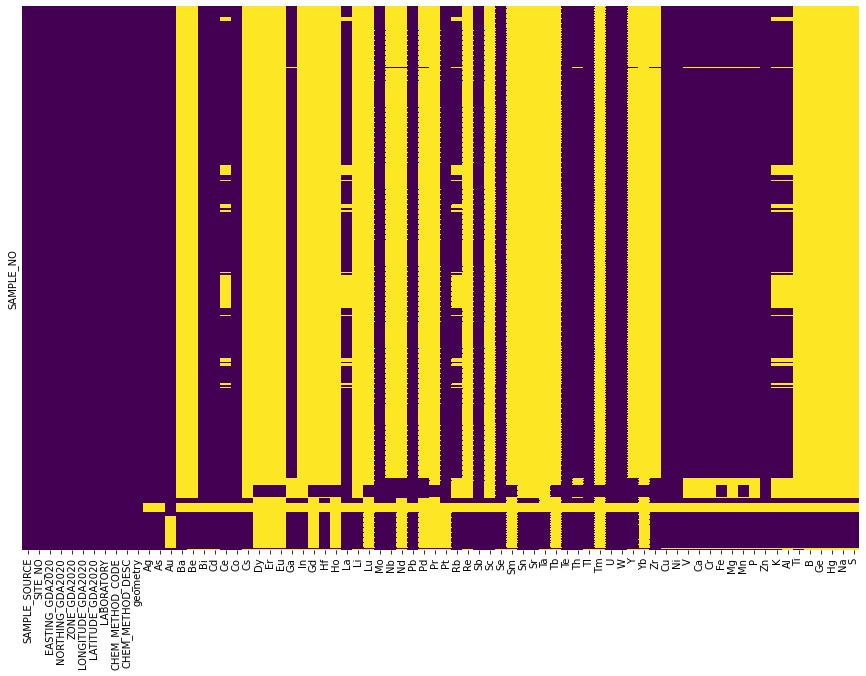

In [45]:
plt.figure(figsize=[15,10])
sns.heatmap(chem_soil.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [56]:
chem_soil_subset = chem_soil.dropna(subset=['Ag','As','Au','Bi','Cd','Ce','Co','Ga','La','Mo','Pt','Rb','Sb','Se','Te',
                                            'Th','Tl','U','W','Cu','Ni','V','Ca','Cr','Fe','Mg','Mn','P','Zn','K','Al'])

In [57]:
chem_soil_subset.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 15304 entries, 519569.0 to 1723984.0
Data columns (total 76 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SAMPLE_SOURCE      15304 non-null  object 
 1   SITE_NO            15304 non-null  float64
 2   EASTING_GDA2020    15304 non-null  float64
 3   NORTHING_GDA2020   15304 non-null  float64
 4   ZONE_GDA2020       15304 non-null  float64
 5   LONGITUDE_GDA2020  15304 non-null  float64
 6   LATITUDE_GDA2020   15304 non-null  float64
 7   LABORATORY         15304 non-null  object 
 8   CHEM_METHOD_CODE   15304 non-null  object 
 9   CHEM_METHOD_DESC   15304 non-null  object 
 10  geometry           15304 non-null  object 
 11  Ag                 15304 non-null  float64
 12  As                 15304 non-null  float64
 13  Au                 15304 non-null  float64
 14  Ba                 159 non-null    float64
 15  Be                 159 non-null    float64
 16  Bi       

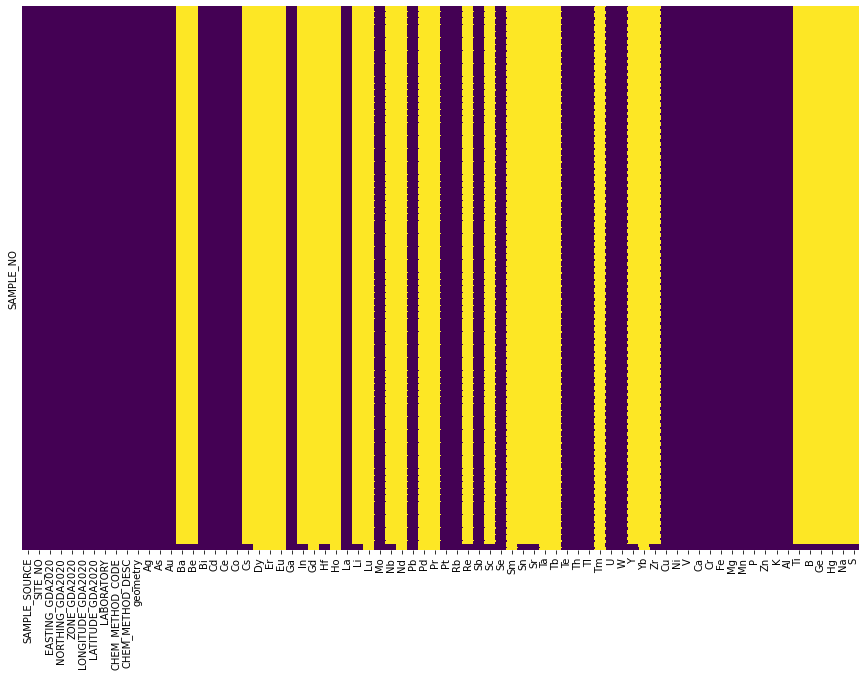

In [58]:
plt.figure(figsize=[15,10])
sns.heatmap(chem_soil_subset.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [59]:
chem_soil_subset.drop(columns=['Ba','Be','Cs','Dy','Er','Eu','In','Gd','Hf','Ho','Li','Lu','Nb','Nd','Pd','Pr','Re','Sc',
                               'Sm','Sn','Sr','Ta','Tb','Tm','Y','Yb','Zr','Ti','B','Ge','Hg','Na','S'],axis=1,inplace=True)

## Visual checking of the data for distribution of null (empty) and non-null cells

### After completion of all the cleaning and preparation steps, the dataset is tuned and ready for investigation and target definition!

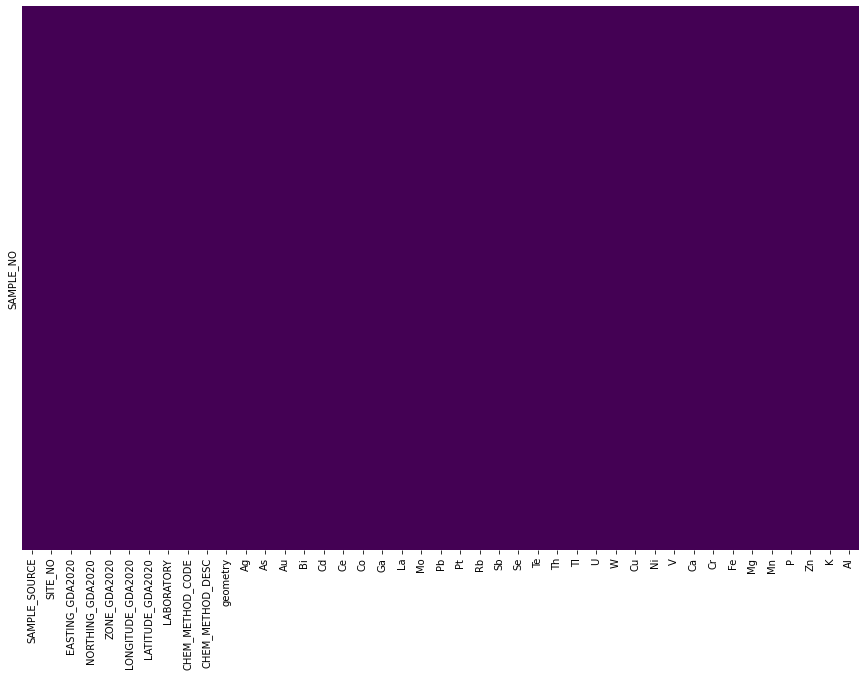

In [60]:
plt.figure(figsize=[15,10])
sns.heatmap(chem_soil_subset.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Saving the final dataframe to a csv


In [61]:
chem_soil_subset.to_csv("sarig_rs_chem_exp_32elements_soil_v3.csv")